In [1]:
import numpy as np
import pandas as pd
import pdb
from ipynb.fs.full.Game import *
from random import randrange

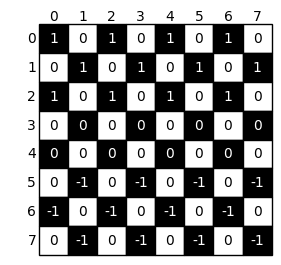

In [2]:
board_1 = np.array([1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1])
state = [board_1, -1]
visualize(state)

In [3]:
bb = np.array([ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,  0, 0, 0, 0,
                0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,])

bb[4] = 1
bb[6] = 1
bb[9] = -1
bb[10] = -1
bb[17] = -1
bb[18] = -1

fix_dict(can_eat([bb, 1, (21,25)])[1], bb)

[[(4, 9), (13, 17)],
 [(4, 9), (13, 18)],
 [(6, 10), (13, 17)],
 [(6, 10), (13, 18)]]

In [4]:
action_space = [(0,4),#0
 (1,4),#1
 (1,5),#2
 (2,5),#3
 (2,6),#4
 (3,6),#5
 (3,7),#6
 (4,0),#7
 (4,1),#8
 (4,8),#9
 (4,9),#10
 (5,1),#11
 (5,2),#12
 (5,9),#13
 (5,10),#14
 (6,2),#15
 (6,3),#16
 (6,10),#17
 (6,11),#18
 (7,3),#19
 (7,11),#20
 (8,4),#21
 (8,12),#22
 (9,4),#23
 (9,5),#24
 (9,12),#25
 (9,13),#26
 (10,5),#27
 (10,6),#28
 (10,13),#29
 (10,14),#30
 (11,6),#31
 (11,7),#32
 (11,14),#33
 (11,15),#34
 (12,8),#35
 (12,9),#36
 (12,16),#37
 (12,17),#38
 (13,9),#39
 (13,10),#40
 (13,17),#41
 (13,18),#42
 (14,10),#43
 (14,11),#44
 (14,18),#45
 (14,19),#46
 (15,11),#47
 (15,19),#48
 (16, 12),#49
 (16, 20),#50
 (17, 12),#51
 (17, 13),#52
 (17, 20),#53
 (17, 21),#54
 (18, 13),#55
 (18, 14),#56
 (18, 21),#57
 (18, 22),#58
 (19, 14),#59
 (19, 15),#60
 (19, 22),#61
 (19, 23),#62
 (20, 16),#63
 (20, 17),#64
 (20, 24),#65
 (20, 25),#66
 (21, 17),#67
 (21, 18),#68
 (21, 25),#69
 (21, 26),#70
 (22, 18),#71
 (22, 19),#72
 (22, 26),#73
 (22, 27),#74
 (23, 19),#75
 (23, 27),#76
 (24, 20),#77
 (24, 28),#78
 (25, 20),#79
 (25, 21),#80
 (25, 28),#81
 (25, 29),#82
 (26, 21),#83
 (26, 22),#84
 (26, 29),#85
 (26, 30),#86
 (27, 22),#87
 (27, 23),#88
 (27, 30),#89
 (27, 31),#90
 (28, 24),#91
 (28, 25),#92
 (29, 25),#93
 (29, 26),#94
 (30, 26),#95
 (30, 27),#96
 (31, 27)]#97

# Q table

## game over

In [7]:
def game_over(board, agent, action_space, turns_without_cap):
    #new_full_state = full_state.copy()
    '''function checks whether game is over and returns tuple bool and winner (as an int)'''
    res = []
    if turns_without_cap == 50:
        return True, 0
    for move in action_space:
        full_state = [board, agent, move]
        res.append(referee(action_space, full_state)[0])
    #if game is over for W check the same for B
    if not any(res):
        winner = - agent
        return True, winner
    return False, 'game not over'

def game_over(board, agent, action_space, turns_without_cap):
    #new_full_state = full_state.copy()
    '''function checks whether game is over and returns tuple bool and winner (as an int)'''
    res = []
    if turns_without_cap == 50:
        return True, 0
    for move in action_space:
        full_state = [board, agent, move]
        res.append(referee(action_space, full_state)[0])
    #if game is over for W check the same for B
    if not any(res):
        winner = - agent
        return True, winner
    
    if not any(res) and agent == -1:
        res_2 = []
        agent = 1
        for move in action_space:
            full_state = [board, agent, move]
            res_2.append(referee(action_space, full_state)[0])
        #if game is over for B as well - return True and 0, i.e. it's a draw ; else B is the winner
        if not any(res_2) :
            return True, 0
        else:
            return True, 1
        
    #if game is over for B check the same for W
    if not any(res) and agent == 1:
        res_2 = []
        agent = -1
        for move in action_space:
            full_state = [board, agent, move]
            res_2.append(referee(action_space, full_state)[0])
        #if game is over for W as well - return True and 0, i.e. it's a draw ; else W is the winner
        if not any(res_2) :
            return True, 0
        else:
            return True, -1

    #pdb.set_trace()
    return False, 'not over'
    

In [8]:
bb = np.array([ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,  0, 0, 0, 0,
                0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,])
a , b = game_over(board_1, -1, action_space, 0)
a == True

False

## learning 

In [9]:
def learning(state,new_state,action,lr,reward,gamma):#state and action are int taken from dictionaries
    Q[state,action] = Q[state,action] + lr * (reward + gamma * np.max(Q[new_state,:]) - Q[state,action])

## Training

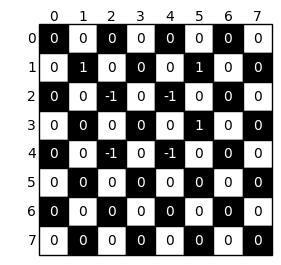

In [10]:
bb = np.array([ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,  0, 0, 0, 0,
                0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,])

bb[4] = 1
bb[6] = 1
bb[9] = -1
bb[10] = -1
bb[14] = 1
bb[17] = -1
bb[18] = -1
visualize([bb, (0,4)])

In [55]:
Q_black

,"(0, 4)","(1, 4)","(1, 5)","(2, 5)","(2, 6)","(3, 6)","(3, 7)","(4, 0)","(4, 1)","(4, 8)",...,"(27, 23)","(27, 30)","(27, 31)","(28, 24)","(28, 25)","(29, 25)","(29, 26)","(30, 26)","(30, 27)","(31, 27)"
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,-100,-100,0,-100,-100,0,0,-100,-100,0,...,0,-100,0,0,0,-100,-100,0,-100,0


In [74]:
black_boards

array([[ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  0,  0,  0,  0,
         0,  0,  0,  0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]])

In [73]:
initialise_board(bb, 1, Q_black, black_boards)

(1,
 array([[ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  0,  0,  0,  0,
          0,  0,  0,  0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
        [ 0,  0,  0,  0,  1,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]]))

In [60]:
def initialise_board(initial_board, agent, Q_color, color_boards):
    '''Function that creates the index (that will be assigned to it in the Q table) for a given board. '''
    #case where board is not in white_boards/black_board
    if sum([(initial_board == board).all() for board in color_boards]) == 0:
        #initialise board in Q table
        color_boards = np.append(color_boards, [initial_board], axis=0)
        #add board index as row  in Q
        ind_board = color_boards.shape[0] -1 
        Q_color.loc[ind_board] = 0

    #case where board was already seen
    else: 
        #first create list where first true is the idx of the board
        ind_board = [idx for idx, bb in enumerate([(initial_board == b).all() for b in color_boards]) if bb][0]

    return ind_board, color_boards

In [12]:
def find_move(initial_board, agent, ind_board, Q_color, color_mult_caps_dict = {}):
    '''finds the best legal move consider all cases where there is more than 1 legal - if move is not legal updates
    Qtable with -100'''
    is_legal = False
    while is_legal == False:
        #choose move by selecting the max col in row representing current board
        moves = list(Q_color.loc[ind_board, Q_color.loc[ind_board] == max(Q_color.loc[ind_board])].index)
        #if more than one optimal move
        #pdb.set_trace()
        if len(moves)>1: 
            #random choice 
            my_move = moves[randrange(len(moves))]
        else:
            my_move = moves[0]

        full_state = [initial_board, agent, my_move]
        #pdb.set_trace()
        is_legal, caps = referee(action_space, full_state)
        if not is_legal:
            #set move to -100 (i.e. illegal)
            Q_color[my_move][ind_board] += -100
        
    #NOW my_move is legal
    #if you can eat
    if caps != 0:
        #pdb.set_trace()
        # RARE: if there are multiple double caps
        if len(caps[0]) > 1 and len(caps) > 1:
            #add board to nested dict of situation with multiple caps for white
            if ind_board not in color_mult_caps_dict.keys():
                color_mult_caps_dict[ind_board] = {}
                for mov in caps:
                    color_mult_caps_dict[ind_board][str(mov)] = 0
            my_move = max(color_mult_caps_dict[ind_board])
            my_move = [mov for mov in caps if str(mov) == my_move][0]
        #case when there's one multiple cap
        elif len(caps[0]) > 1:
            my_move = caps[0]
            
    return my_move

In [13]:
def update_board(initial_board,  agent, ind_board, my_move, color_hist, turns_without_cap = 0):
    '''return new board and updates the number of turns without cap'''
    #update board after move
    #first rare case where there are multiple caps
    if type(my_move) == list:
        turns_without_cap = 0
        for cap in my_move:
            initial_board = nextState([initial_board, agent, cap], cap)
    #all other cases (single cap or simple move)
    else:
        if initial_board[my_move[1]] != 0:
            turns_without_cap = 0
        else:
            turns_without_cap += 1
        initial_board = nextState([initial_board, agent, my_move], my_move)
    visualize([initial_board, agent])
    #add to history of moves in this game for white
    color_hist[ind_board]= my_move
    return initial_board, turns_without_cap

In [76]:
def Q_table_update(Q_table, color_hist, color_mult_caps_dict, agent, winner):

    if winner:
        #for every board index and move
        for ind, moves in color_hist.items():
            #if move is not multiple caps update Q_table with positive reward
            #pdb.set_trace()
            if type(moves) == tuple:
                Q_table[moves][ind] += 0.5
        
            #if multiple caps enter the nested dict
            else:
                if str(moves) in color_mult_caps_dict[ind].keys():
                    color_mult_caps_dict[ind][str(moves)] += 0.5
                else:
                    color_mult_caps_dict[ind] = {str(moves): 0.5}
                   
        
    else:
        #for every board index and move
        for ind, moves in color_hist.items():
            #if move is not multiple caps update Q_table with negative reward
            if type(moves) == tuple:
                Q_table[moves][ind] += -0.5#####CHANGEEEEEEE
        
            #if multiple caps enter the nested dict
            else:
                if str(moves) in color_mult_caps_dict[ind].keys():
                    color_mult_caps_dict[ind][str(moves)] += -0.5
                else:
                    color_mult_caps_dict[ind] = {str(moves): -0.5}
                        
    #reset history for new game MAYBE NOT NECESSARY
    color_hist = {}
    return Q_table, color_mult_caps_dict

In [111]:
d = {2: (2,3), 1:(2,3)}
d[-3] = (2,3)
for ind, moves in enumerate(d):
    print(ind, moves, d[moves])

0 2 (2, 3)
1 1 (2, 3)
2 -3 (2, 3)


In [110]:
len(d)

3

# HERE

left off here, write case where move is not tuple and decide whether Q_table_update is of any use!! Keep on rolling brov

In [ ]:
def bell_eq(Q_color, color_hist, lr, reward, discount_factor):
    
    #for every board index and move
    for move_number, ind in enumerate(color_hist):
        move = color_hist[ind]
        if type(move) == tuple:
            if move_number < len(color_hist)-1:
                next_move_val = Q_color[color_hist[ind+1]][ind+1]
            else:
                next_move_val = 1
            
            old_value = Q_color[move][ind]
            Q_color[move][ind] = (1-lr)* old_value + lr*(reward + discount_factor * next_move_val)
    
        else:
            
            
            
    return Q_color

In [86]:
def training_Q(initial_board, agent, Q_white, Q_black, white_boards, black_boards, white_mult_caps_dict, 
            black_mult_caps_dict, white_hist = {}, black_hist = {}, game_is_over = False, turns_without_cap = 0):

    while game_is_over == False:
        if agent == -1:
            ind_board, white_boards = initialise_board(initial_board, agent, Q_white, white_boards)
            my_move = find_move(initial_board, agent, ind_board, Q_white, white_mult_caps_dict)
            initial_board, turns_without_cap = update_board(initial_board, agent, ind_board, my_move, white_hist)
            agent = 1
            game_is_over, winner = game_over(initial_board, agent, action_space, turns_without_cap)
            if game_is_over == True:
                Q_white, white_mult_caps_dict = Q_table_update(Q_white, white_hist, white_mult_caps_dict, -1, True)
                Q_black, black_mult_caps_dict = Q_table_update(Q_black, black_hist, black_mult_caps_dict, 1, False)
                return 'and the winner is ' , winner

            #return new_board, turns_without_cap
        
        elif agent == 1:
            ind_board, black_boards = initialise_board(initial_board, agent, Q_black, black_boards)
            #pdb.set_trace()
            my_move = find_move(initial_board, agent, ind_board, Q_black, black_mult_caps_dict)
            initial_board, turns_without_cap = update_board(initial_board, agent, ind_board, my_move, black_hist)
            agent = -1
            game_is_over, winner = game_over(initial_board, agent, action_space, turns_without_cap)
            if game_is_over == True:
                Q_black, black_mult_caps_dict = Q_table_update(Q_black, black_hist, black_mult_caps_dict, 1, True)
                Q_white, white_mult_caps_dict = Q_table_update(Q_white, white_hist, white_mult_caps_dict, -1, False)
                return 'and the winner is ' , winner,black_boards
    


    white_hist = {}
    black_hist = {}
    
    return initial_board

In [101]:
black_mult_caps_dict

{2: {'[(4, 9), (13, 17)]': 0, '[(5, 9), (12, 17)]': 1.0}}

In [102]:
Q_black.loc
Q_black.loc[[1], [(4,9)]]

,"(4, 9)"
1,2.0


> /var/folders/k4/4m28kxjd6l712gcj21bkw3fh0000gn/T/ipykernel_11189/3149157757.py(21)training_Q()
     19             ind_board, black_boards = initialise_board(initial_board, agent, Q_black, black_boards)
     20             pdb.set_trace()
---> 21             my_move = find_move(initial_board, agent, ind_board, Q_black, black_mult_caps_dict)
     22             initial_board, turns_without_cap = update_board(initial_board, agent, ind_board, my_move, black_hist)
     23             agent = -1

ipdb> c


/var/folders/k4/4m28kxjd6l712gcj21bkw3fh0000gn/T/ipykernel_11189/1013862122.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Q_color[my_move][ind_board] += -100


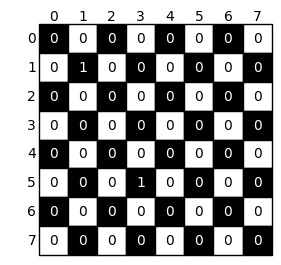

/var/folders/k4/4m28kxjd6l712gcj21bkw3fh0000gn/T/ipykernel_11189/186530320.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Q_table[moves][ind] += 0.5


In [100]:
#STORING value after running training_Q!!!!
a,b, black_boards = training_Q(bb, 1, Q_white, Q_black, white_boards, black_boards, white_mult_caps_dict, 
            black_mult_caps_dict, white_hist, black_hist)

In [103]:
white_hist

{}

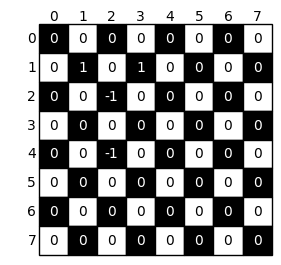

In [97]:
bb = np.array([ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,  0, 0, 0, 0,
                0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,])

bb[4] = 1
bb[5] = 1
bb[9] = -1
bb[17] = -1

visualize([bb, (0,4)])

In [203]:
#Q_white.loc[[0], [(1,4)]].values()# += -0.5
Q_white[(1,4)][0] #= 0.5

0.0

In [156]:
game_over(bb, -1, action_space, 20)

(True, 1)

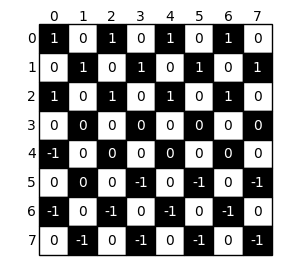

(array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  0,  0,  0,  0,  0,
         0,  0,  0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]),
 1)

In [58]:
update_board(board_1, -1, 1, (20,16), [])

In [77]:
Q_white.loc[[0],[(0,4)]] += 3
Q_white.loc[[0],[(0,4)]]

,"(0, 4)"
0,9


In [14]:
Q_white = pd.DataFrame(data = 0, index=[0], columns=action_space)
Q_white.head()

,"(0, 4)","(1, 4)","(1, 5)","(2, 5)","(2, 6)","(3, 6)","(3, 7)","(4, 0)","(4, 1)","(4, 8)",...,"(27, 23)","(27, 30)","(27, 31)","(28, 24)","(28, 25)","(29, 25)","(29, 26)","(30, 26)","(30, 27)","(31, 27)"
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [80]:
board_1 = np.array([1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1])
Q_white = pd.DataFrame(data = 0, index=[0], columns=action_space)
Q_black = pd.DataFrame(data = 0, index=[0], columns=action_space)
white_boards = np.array([board_1])
black_boards = np.array([board_1])
white_mult_caps_dict = {}
black_mult_caps_dict = {}
white_hist = {} #ind_board as key and move as value
black_hist = {}

## Game

In [ ]:
def game(initial_board):
    '''First thing is to create the Q_table and the other necessary tables/dict to keep track of the score. It is 
    also crucial that these are then stored somewhere in order to NOT START AGAIN.
    Within a while loop call the training and the game over functions for white then black, back and forth,
    until the game is over. Then finally update the Q_tables.'''
    
    while game_is_over = False:
        training_white()
        game_is_over = game_over(board, 1, action_space)    
        training_black()
        game_is_over = game_over(board, -1, action_space)
    
    
    

In [ ]:
def training_white(initial_board, agent = -1, white_boards = np.array([board_1]), white_hist = [], 
                   white_mult_caps_dict={}):
    '''Problem with this function is that it relies on Q_white which relies on white_state_dict both defined outside
    the function. In addition there are many table/list that are important to the training purpose. NEED to 
    understand what it will return!
    '''
    if sum([(initial_board == board).all() for board in white_boards]) == 0:
        #initialise board in Q table
        white_boards = np.append(white_boards, [initial_board], axis=0)
        #add board index as row  in Q
        ind_board = white_boards.shape[0] -1 
        Q_white.loc[ind_board] = 0

    #case where board was already seen
    else: 
        #first create list where first true is the idx of the board
        ind_board = [idx for idx, bb in enumerate([(initial_board == b).all() for b in white_boards]) if bb][0]

    is_legal = False
    while is_legal == False:
        #choose move by selecting the max col in row representing current board
        moves = list(Q_white.loc[ind_board, Q_white.loc[ind_board] == max(Q_white.loc[ind_board])].index)
        #if more than one optimal move
        if len(moves)>1: 
            #random choice 
            my_move = moves[randrange(len(moves))]
        else:
            my_move = moves

        full_state = [initial_board, agent, my_move]
        is_legal, caps = referee(action_space, full_state)
        if not is_legal:
            #set move to -100 (i.e. illegal)
            Q_white.loc[[ind_board], [my_move]] += -100

    #NOW my_move is legal
    #if you can eat
    if caps != 0:
        # RARE: if there are multiple double caps
        if len(caps[0]) > 1 and len(caps) > 1:
            #add board to nested dict of situation with multiple caps for white
            if ind_board not in white_mult_caps_dict.keys():
                white_mult_caps_dict[ind_board] = {}
                for mov in caps:
                    white_mult_caps_dict[ind_board][str(mov)] = 0
            my_move = max(white_mult_caps_dict[ind_board])
            my_move = [mov for mov in caps if str(mov) == my_move][0]
        
        #case when there's one multiple cap
        elif len(caps[0]) > 1:
            pdb.set_trace()
            my_move = caps[0]
    #update board after move
    #first rare case where there are multiple caps
    if type(my_move) == list:
        for cap in my_move:
            initial_board = nextState([initial_board, agent, cap], cap)
    #all other cases (single cap or simple move)
    else:
        initial_board = nextState([initial_board, agent, my_move], my_move)
    visualize([initial_board, agent])
    #add to history of moves in this game for white
    white_hist.append(my_move)

        
        

# Luigi

In [22]:
numbers = np.arange(1,99,1)

In [23]:
action_dict = dict(zip(numbers,action_space))

In [24]:
action_dict

{1: (0, 4),
 2: (1, 4),
 3: (1, 5),
 4: (2, 5),
 5: (2, 6),
 6: (3, 6),
 7: (3, 7),
 8: (4, 0),
 9: (4, 1),
 10: (4, 8),
 11: (4, 9),
 12: (5, 1),
 13: (5, 2),
 14: (5, 9),
 15: (5, 10),
 16: (6, 2),
 17: (6, 3),
 18: (6, 10),
 19: (6, 11),
 20: (7, 3),
 21: (7, 11),
 22: (8, 4),
 23: (8, 12),
 24: (9, 4),
 25: (9, 5),
 26: (9, 12),
 27: (9, 13),
 28: (10, 5),
 29: (10, 6),
 30: (10, 13),
 31: (10, 14),
 32: (11, 6),
 33: (11, 7),
 34: (11, 14),
 35: (11, 15),
 36: (12, 8),
 37: (12, 9),
 38: (12, 16),
 39: (12, 17),
 40: (13, 9),
 41: (13, 10),
 42: (13, 17),
 43: (13, 18),
 44: (14, 10),
 45: (14, 11),
 46: (14, 18),
 47: (14, 19),
 48: (15, 11),
 49: (15, 19),
 50: (16, 12),
 51: (16, 20),
 52: (17, 12),
 53: (17, 13),
 54: (17, 20),
 55: (17, 21),
 56: (18, 13),
 57: (18, 14),
 58: (18, 21),
 59: (18, 22),
 60: (19, 14),
 61: (19, 15),
 62: (19, 22),
 63: (19, 23),
 64: (20, 16),
 65: (20, 17),
 66: (20, 24),
 67: (20, 25),
 68: (21, 17),
 69: (21, 18),
 70: (21, 25),
 71: (21, 26)

In [25]:
initial_state = [1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1]

In [26]:
zeros = np.zeros((1,98))

In [27]:
Q = np.zeros((1,98))

In [28]:
Q

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.]])

In [29]:
rows = {'1' : [1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1]}

In [30]:
state = (1,1,1,1,1,2,2,3,5,11,2,3,4,5,2,1,4)

In [31]:
def learning(state,new_state,action,lr,reward,gamma):#state and action are int taken from dictionaries
    Q[state,action] = Q[state,action] + lr * (reward + gamma * np.max(Q[new_state,:]) - Q[state,action])

In [32]:
def game_over(board):
    negative_counter = 0
    positive_counter = 0
    #CHANGE
    for x in action_space:
        if referee(x)[0] == True:
            return False
    #PROB delete
    for x in board:
        if x < 0:
            negative_counter += 1
        elif x > 0:
            positive_counter += 1
    if negative_counter > 0 and positive_counter > 0:
        return False
    return True
    

In [33]:
def determine_reward():
    if referee(action_space,full_state)[0] == False:
        return -1
    elif game_over() == True:
        return 1 #don't understand why
    else:
        return 0

In [34]:
def append_dict(state,Q):
    if state not in rows.values():
        rows[f'{len(rows)+1}'] = state
        Q = np.append(Q,zeros,axis = 0)
        return Q
    return Q

In [35]:
Q = append_dict([1,2,3,4,5,6,7,8,9],Q)

In [36]:
rows

{'1': [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1],
 '2': [1, 2, 3, 4, 5, 6, 7, 8, 9]}

In [37]:
Q.shape

(2, 98)

In [38]:
rows

{'1': [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1],
 '2': [1, 2, 3, 4, 5, 6, 7, 8, 9]}

In [39]:
def get_temporal_difference(state_index,move_index,reward,gamma):
    max_action = np.argmax(Q[state_index])
    max_Q = Q[state_index][max_action]
    current_Q = Q[state_index][move_index]
    return reward + (gamma * (max_Q - current_Q))

# training

In [40]:
lr = 1
gamma = 0.8
reward = 0

In [41]:
full_state = [[0,1,1,1,1],1,(4,10)]

In [42]:
state = full_state[0]

In [43]:
def epsilon_greed(current_board,epsilon):
    state_number = 0
    for number,board_state in rows.items():
        if board == current_board:
            state_number = number
        else:
            append_dict(full_state[0])
    if np.random.random() < epsilon:
        return np.argmax(Q[state_number])
    else:
        return np.random.randint(98)

In [44]:
full_state = []

In [45]:
np.argmax(Q[1])

0

In [46]:
Q[1][19] = 23

In [47]:
def get_move(index):
    return action_space[index]

In [157]:
for episode in range(1000):
    board = full_state[0]
    state_index = 0
    for number,board_state in rows.items():
        if board == full_state[0]:
            state_index = number
        else:
            append_dict(full_state[0])
            for number,board_state in rows.items():
                if board == full_state[0]:
                    state_index = number
            
    while game_over(board) == False:
        move_index = epsilon_greed(full_state,epsilon)
        move = get_move(move_index)
        legal_boolean = referee(full_state) #referee the move
        if legal_boolean == False:
            reward = -1
            temporal_difference = get_temporal_difference
            Q[state_index][move_index] = Q[state_index][move_index] + lr * temporal_difference
            continue 
        reward = get_reward()
        nextState()
        Q[state_index][move_index] = Q[state_index][move_index] + lr * temporal_difference

NameError: name 'rows' is not defined